In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pygdsm as pgsm
import healpy as hp
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, ICRS
import astropy.units as u
from astropy.time import Time
import datetime as dt
import numpy.ma as ma

def gaussian2D(theta,phi,rot_x,cen_th,cen_phi,width_th,width_phi,A):
    a = (((np.cos(rot_x))**2)/(2*width_th**2)) + (((np.sin(rot_x))**2)/(2*width_phi**2))
    b = (-(np.sin(2*rot_x))/(4*width_th**2)) + ((np.sin(2*rot_x))/(4*width_phi**2))
    c = (((np.sin(rot_x))**2)/(2*width_th**2)) + (((np.cos(rot_x))**2)/(2*width_phi**2))
    return A*np.exp(-(a*(theta-cen_th)**2 + 2*b*(theta-cen_th)*(phi-cen_phi) + c*(phi-cen_phi)**2))

def decimal2dt(yyyy,mm,dd,time):
    return dt.datetime(yyyy,mm,dd,int(time),int((time-int(time))*60),int((((time-int(time))*60)-int((time-int(time))*60))*60))

def lst2ut(lst,lon):
    # convert sidereal time object and convert it to UT
    # enter this as decimal number
    gst = (lst - lon) + (lst-lon)%24

In [11]:
gsm = pgsm.GlobalSkyModel(freq_unit='MHz')
freq = np.linspace(80,300,(301-80))
model_sky = gsm.generate(freqs=freq)


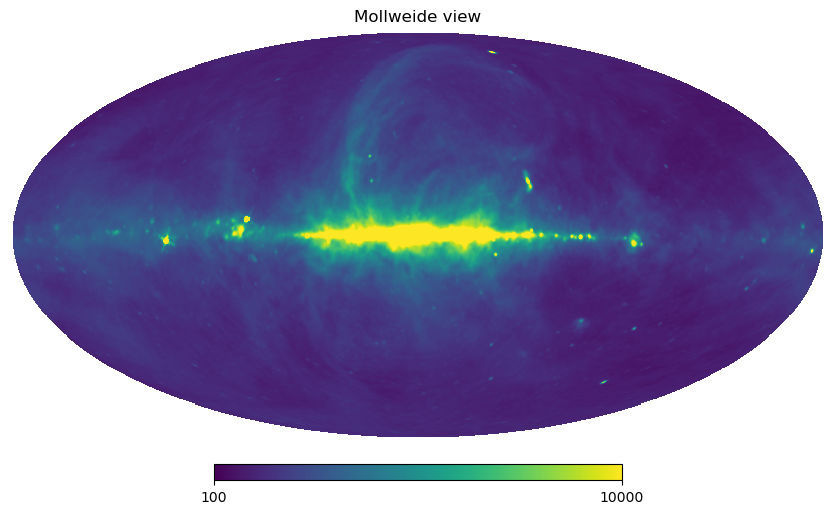

In [12]:
nside = hp.npix2nside(model_sky.shape[1])
lb_00 = hp.ang2pix(nside,theta=0,phi=0,lonlat=True)
lb_90_0 = hp.ang2pix(nside,theta=90,phi=0,lonlat=True)
hp.mollview(model_sky[0,:],max=10000,min=100)


Text(0.5, 0, 'Frequency (MHz)')

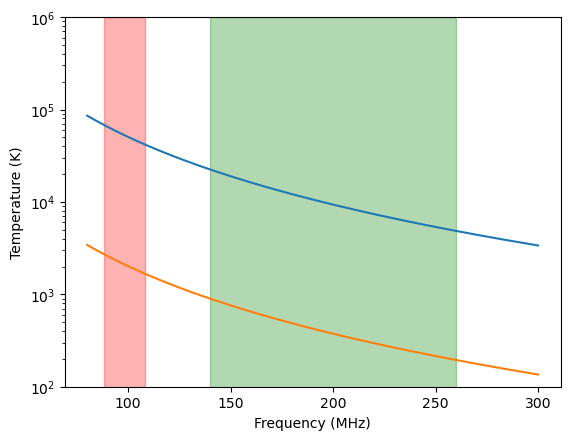

In [13]:
plt.plot(freq,model_sky[:,lb_00],label='Galaxy Max.')
plt.plot(freq,model_sky[:,lb_90_0],label='Galaxy Min.')
plt.yscale('log')
plt.fill_betweenx(y=[0,10**6],x1=88,x2=108,alpha=0.3,color='red',label='FM Band')
plt.fill_betweenx(y=[0,10**6],x1=140,x2=260,alpha=0.3,color='green',label='Band of Interest')
plt.ylim(100,10**6)
plt.ylabel('Temperature (K)')
plt.xlabel('Frequency (MHz)')


In [318]:
# as we will use an lpda which will have a finite beam size, we can use a gaussian beam model for this, 
# and see how this will affect the beam
# we will try to compute the galactic coordinates for every time instant in UTC
# and use that to find out what the Tsys will be at each lst
theta = np.arange(-90,91,1) + 90
phi = np.arange(-180,181,1)
theta_m, phi_m = np.meshgrid(theta,phi)
clpda_beam = gaussian2D(theta=theta_m,phi=phi_m,rot_x=0,cen_th=90,cen_phi=0,width_th=60,width_phi=60,A=1)

# Beam HP
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
beam_hp=np.zeros((1,NPIX))
theta_rs = np.deg2rad(np.reshape(theta_m,(1,np.shape(theta_m)[0]*np.shape(theta_m)[1])))
phi_rs = np.deg2rad(np.reshape(phi_m,(1,np.shape(phi_m)[0]*np.shape(phi_m)[1])))
pxls = hp.ang2pix(NSIDE,theta_rs,phi_rs)
beam_rs = np.reshape(clpda_beam,(1,np.shape(clpda_beam)[0]*np.shape(clpda_beam)[1]))
beam_hp[0,pxls] = beam_rs 


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

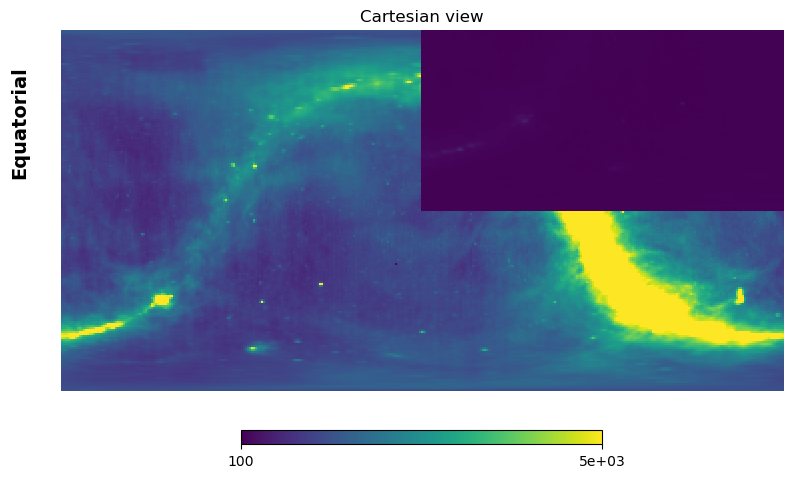

In [337]:
sky_80 = hp.cartview(model_sky[0,:],return_projected_map=True,xsize=len(phi),ysize=len(theta),coord=['G','C'],min=100,max=5000)
plt.imshow(sky_80)

In [16]:
Ooty_CRL = EarthLocation.from_geodetic(lon=76.7,lat=11.4,height=2220*u.m)
hrs = np.arange(0,24,0.25)
lst = np.zeros((len(hrs)))
ra = np.arange(0,361,1)
dec = np.arange(-90,91,1)
ra_mesh, dec_mesh = np.meshgrid(ra,dec)
for t, time in enumerate(hrs):
    lst[t] = (Time(decimal2dt(2025,7,7,time),scale='utc').sidereal_time('apparent',longitude=Ooty_CRL.lon).hour)

In [ ]:
# elevation cut-off -- 90 deg.
'''
ra_dec_mask = np.zeros_like(ra_mesh)
ra_dec_mask_list = np.zeros((len(hrs),ra_dec_mask.shape[0],ra_dec_mask.shape[1]))
light_curve_80mhz = np.zeros(len(hrs))
ut = []
lst = []
vis_sky_80mhz = np.zeros((len(hrs),ra_dec_mask.shape[0],ra_dec_mask.shape[1]))
for t, time in enumerate(hrs):
    ra_dec_mask = np.zeros_like(ra_mesh)
    utc = Time(decimal2dt(2025,7,7,time),scale='utc')
    lst_i = utc.sidereal_time(longitude=Ooty_CRL.lon,kind='apparent')
    Ooty_CRL_Frame = AltAz(location=Ooty_CRL,obstime=utc)
    az_el = SkyCoord(ra_mesh,dec_mesh,unit=u.deg,frame=ICRS).transform_to(Ooty_CRL_Frame)
    ut.append(utc)
    lst.append(lst_i.value)
    el, az = az_el.alt.value, az_el.az.value
    ra_dec_mask[np.where(el<=0)] = 0
    ra_dec_mask[np.where(el>0)] = 1
    ra_dec_mask_list[t,:,:] = ra_dec_mask
    vis_sky_80mhz[t,:,:] = ra_dec_mask*sky_80[:,:]
    light_curve_80mhz[t] = np.mean(vis_sky_80mhz[t,:,:])
'''
#el = el[::-1,:]
# trying with pygdsm to verify masks
lst = []
light_curve_gsm = []
freqs = np.arange(80,300,20)
for f in freqs:
    lc_curr_freq = []
    for t, time in enumerate(hrs):
        ov = pgsm.GSMObserver()
        ov.lon = Ooty_CRL.lon.value
        ov.lat = Ooty_CRL.lat.value
        ov.elev = Ooty_CRL.height.value
        ut_now = Time(decimal2dt(2025,7,7,time),scale='utc')
        ov.date = ut_now.datetime
        if f == freqs[0]:
            lst.append((ut_now.sidereal_time(longitude=Ooty_CRL.lon,kind='apparent').value))
        ov.generate(f)
        d = ov.view(max=5000,min=200)
        plt.close()
        
        d_dg = hp.ud_grade(d,nside_out=NSIDE)
        light_curve_time.append( np.nanmean( d_dg*beam_hp )/np.nanmean(beam_hp) )


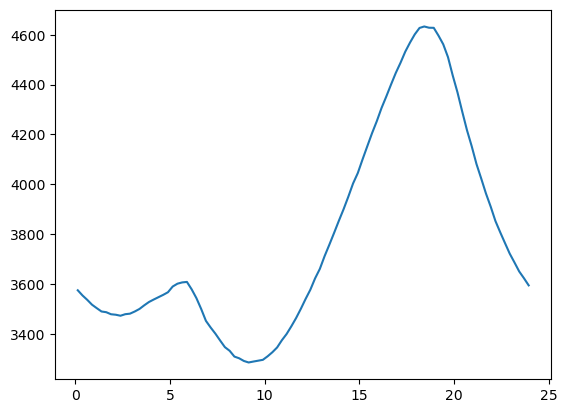

In [338]:
plt.plot(lst,light_curve_gsm)


In [329]:
lst[np.argmax(light_curve_gsm)]

np.float64(18.427738138005815)